In [45]:
import numpy as np
import pandas as pd
import scanpy as sc
import muon as mu
import matplotlib.pyplot as plt
from muon import atac as ac
from muon import prot as pt
import anndata as ad
import seaborn as sns
import random
import os
import scipy
from scipy.stats import median_abs_deviation


In [64]:
adata = sc.read_10x_mtx('/Users/alexandra/Desktop/Data/Single-Cell/hg19_10xCloud_aligned_data/filtered_feature_bc_matrix', gex_only = False)

gex_rows = list(map(lambda x: x == 'Gene Expression', adata.var['feature_types']))
atac_rows = list(map(lambda x: x == 'Peaks', adata.var['feature_types']))

adata_gem = adata[:, gex_rows].copy()
adata_atac = adata[:, atac_rows].copy()

adata_gem.var_names_make_unique()
adata_atac.var_names_make_unique()

In [65]:
# mitochondrial genes
adata_gem.var["mt"] = adata_gem.var_names.str.startswith("MT-")
# ribosomal genes
adata_gem.var["ribo"] = adata_gem.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes.
adata_gem.var["hb"] = adata_gem.var_names.str.contains("^HB[^(P)]")

In [ ]:
# calculate qc metrics
sc.pp.calculate_qc_metrics(
    adata_gem, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)
adata_gem

AnnData object with n_obs × n_vars = 11112 × 20346
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

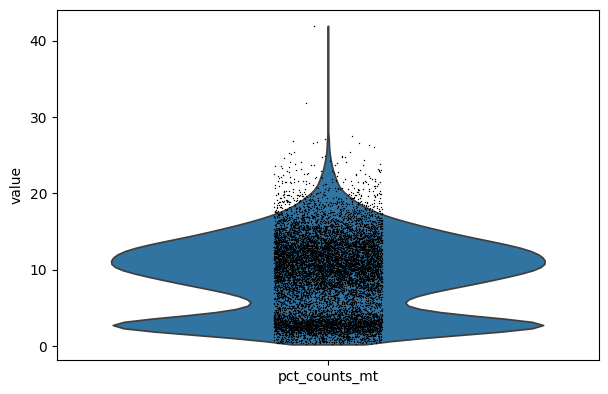

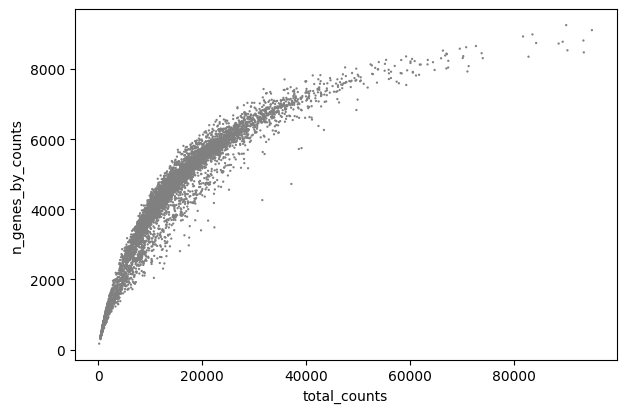

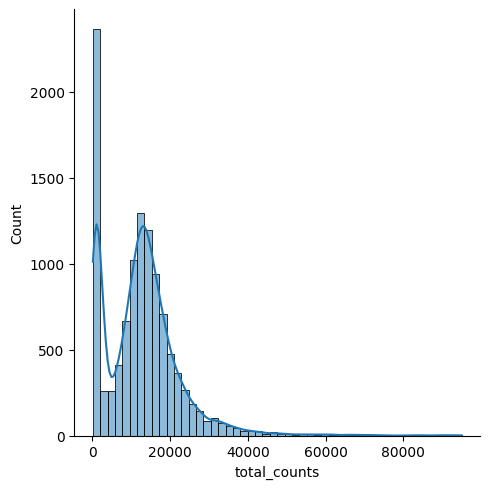

In [67]:
p1 = sc.pl.violin(adata_gem, ["pct_counts_mt"])
p2 = sc.pl.scatter(adata_gem, x="total_counts", y="n_genes_by_counts")
p3 = sns.displot(adata_gem.obs["total_counts"], bins=50, kde=True)

In [ ]:
# filter cells by MADs
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (np.median(M) + nmads * median_abs_deviation(M) < M )
    return outlier 

In [ ]:
# filter cells by MADs
adata_gem.obs["outlier"] = (
    is_outlier(adata_gem, "total_counts", 5)
  | is_outlier(adata_gem, "n_genes_by_counts", 5)
)

adata_gem.obs.outlier.value_counts()

outlier
False    10935
True       177
Name: count, dtype: int64

In [ ]:
adata_gem.obs["mt_outlier"] = adata_gem.obs["pct_counts_mt"] > 20
adata_gem.obs.mt_outlier.value_counts()

mt_outlier
False    10957
True       155
Name: count, dtype: int64

In [ ]:
adata_gem = adata_gem[~adata_gem.obs["outlier"] & ~adata_gem.obs.mt_outlier].copy()
adata_gem

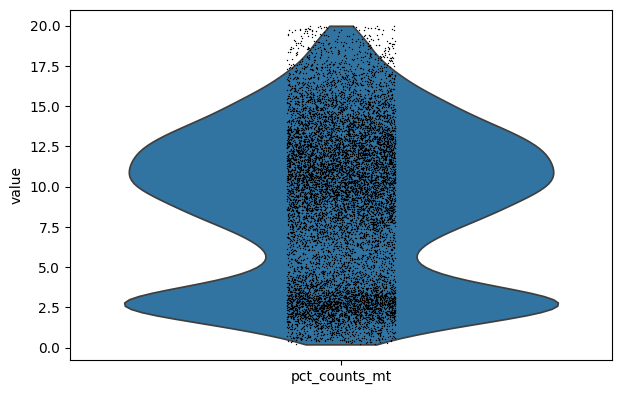

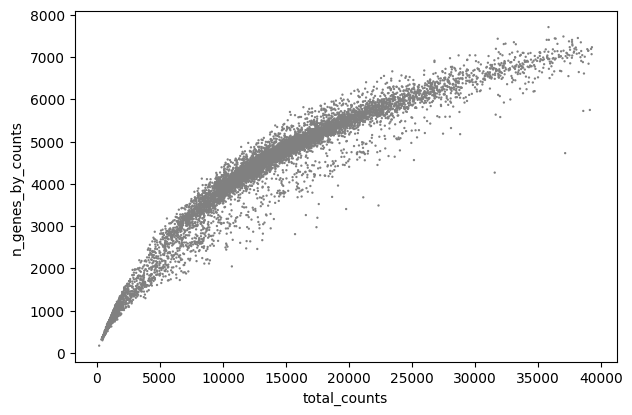

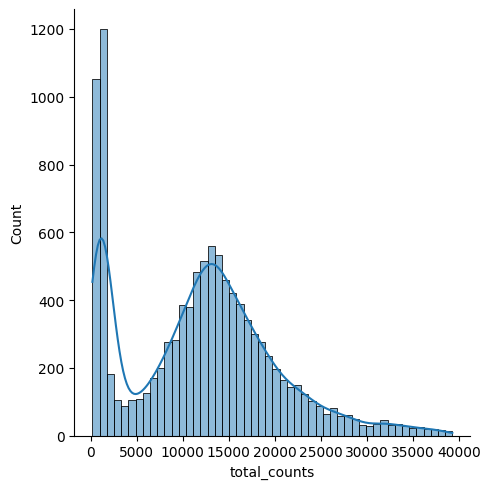

In [72]:
p1 = sc.pl.violin(adata_gem, ["pct_counts_mt"])
p2 = sc.pl.scatter(adata_gem, x="total_counts", y="n_genes_by_counts")
p3 = sns.displot(adata_gem.obs["total_counts"], bins=50, kde=True)

In [83]:
# fitler genes
sc.pp.filter_genes(adata_gem, min_cells=20)
adata_gem = adata_gem[:,~adata_gem.var["mt"]& ~adata_gem.var["ribo"] & ~adata_gem.var["hb"]].copy()
adata_gem

AnnData object with n_obs × n_vars = 10791 × 13703
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

In [84]:
# Normalization
sc.pp.normalize_total(adata_gem, target_sum=1e4)
sc.pp.log1p(adata_gem)